# Importing necesssary library and packages


In [29]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Let’s load the Facebook pages as the nodes and mutual likes between the pages as the edges:

In [30]:
import os
os.chdir("E:\LinearRegression")

with open("fb-pages-food.nodes",encoding="utf8") as f:
    fb_nodes = f.read().splitlines() 
    
# load edges (or links)
with open("fb-pages-food.edges",encoding="utf8") as f:
    fb_links = f.read().splitlines()     

In [31]:
node_list_1 = []
node_list_2 = []

for i in tqdm(fb_links):
  node_list_1.append(i.split(',')[0])
  node_list_2.append(i.split(',')[1])

fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

100%|██████████| 2102/2102 [00:00<00:00, 254559.88it/s]


In [32]:
fb_df.head(20)

,node_1,node_2
0,0,276
1,0,58
2,0,132
3,0,603
4,0,398
5,0,555
6,1,265
7,1,611
8,2,265
9,2,182


The nodes ‘276’, ’58’, ‘132’, ‘603’, and ‘398’ form links with the node ‘0’ and '265','611'form links with the node '1'. We can easily represent this arrangement of Facebook pages in the form of a graph 

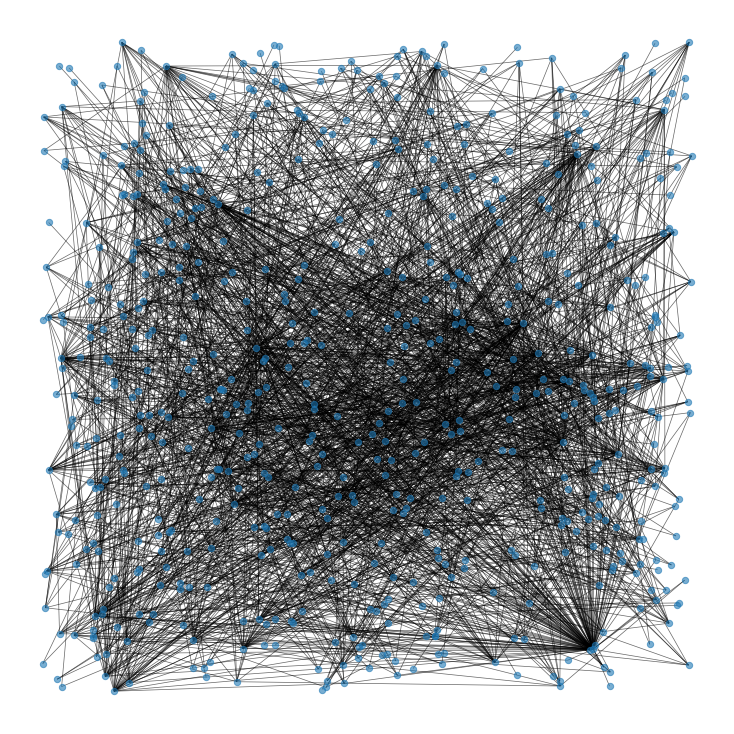

In [33]:
# create graph
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

This is what we are going to deal with – a wire mesh of Facebook pages (blue dots). The black lines are the links or edges connecting all the nodes to each other.

# Dataset Preparation for Model Building

We need to prepare the dataset from an undirected graph. This dataset will have features of node pairs and the target variable would be binary in nature, indicating the presence of links (or not).


# Retrieve Unconnected Node Pairs – Negative Samples

We have already understood that to solve a link prediction problem, we have to prepare a dataset from the given graph. A major part of this dataset is the negative samples or the unconnected node pairs. In this section, I will show you how we can extract the unconnected node pairs from a graph.

In [34]:
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)
adj_G.shape

(620, 620)

In [35]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
      if nx.shortest_path_length(G, str(i), str(j)) <=2:
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1

100%|██████████| 620/620 [00:28<00:00, 22.01it/s]


Here’s how many unconnected node pairs we have in our dataset:

In [36]:
len(all_unconnected_pairs)

19018

We have 19,018 unconnected pairs. These node pairs will act as negative samples during the training of the link prediction model. Let’s keep these pairs in a dataframe:

# Remove Links from Connected Node Pairs – Positive Samples

As we discussed above, we will randomly drop some of the edges from the graph. However, randomly removing edges may result in cutting off loosely connected nodes and fragments of the graph. This is something that we have to take care of. We have to make sure that in the process of dropping edges, all the nodes of the graph should remain connected.


In [41]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

In [42]:
initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(fb_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)

100%|██████████| 2102/2102 [00:25<00:00, 82.47it/s] 


In [43]:
len(omissible_links_index)

1483

We have over 1400 links that we can drop from the graph. These dropped edges will act as positive training examples during the link prediction model training

# Data for Model Training

Next, we will append these removable edges to the dataframe of unconnected node pairs. Since these new edges are positive samples, they will have a target value of ‘1’:

In [44]:
# create dataframe of removable edges
fb_df_ghost = fb_df.loc[omissible_links_index]

# add the target variable 'link'
fb_df_ghost['link'] = 1

data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

Let’s check the distribution of values of the target variable:



In [46]:
data['link'].value_counts()

0    19018
1     1483
Name: link, dtype: int64

We will use the node2vec algorithm to extract node features from the graph after dropping the links. So, let’s first create a new graph after dropping the removable links:

In [57]:
# drop removable edges
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

we will install the node2vec library. It is quite similar to the DeepWalk algorithm. However, it involves biased random walks.
# node2vec is used for vector representation of nodes of a graph

In [72]:
import warnings
warnings.filterwarnings("ignore")

In [73]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:46<00:00,  1.09it/s]


In [77]:
x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]


Building our Link Prediction Model

To validate the performance of our model, we should split our data into two parts – one for training the model and the other to test the model’s performance

In [78]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)
lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

We will now make predictions on the test set:

In [81]:
predictions = lr.predict_proba(xtest)
roc_auc_score(ytest, predictions[:,1])

0.7985196884340038